## 9-2 순환 신경망으로 IMDB 리뷰 분류하기  
앞서 살펴본 RNN을 중심으로 이번에는 대표적인 RNN 문제라고 할 수 있는 IMDB 리뷰 데이터 셋을 활용해서 가장  
간단한 RNN 모델을 훈련해 보자! 이 데이터셋을 두 가지 방법으로 변형하여 RNN에 주입할 것임ㅇㅇ  
하나는 One-hot encoding이고 또 다른 하나는 단어 임베딩이다. 이 두 가지 방법의 차이점에 대해서 설명하고  
순환 신경망을 만들 때 고려해야 할 점을 알아보자!

일단 IMDB 리뷰 데이터셋은 잘 알려진 영화 DB인 imdb.com에서 수집한 리뷰를 감상평에 따라 긍정과 부정으로  
분류해 놓은 데이터 셋이다. 총 50,000개의 샘플로 이루어져 있고 훈련 데이터와 테스트 데이터에 각각 절반씩  
나눠져 있다. 이런 데이터셋을 corpus라고 하는데 말뭉치라고 부름ㅇㅇ IMDB 데이터셋이 하나의 말뭉치이다!

사실 text 데이터 자체를 신경망에 전달하는 건 아님ㅇㅇ 컴퓨터가 처리하는 모든 것은 어떤 숫자 데이터이다!!  
앞서 합성곱 신경망에서는 이미지를 다룰 때는 특별한 변환이 없었음! 이미지 데이터는 이미 정수 픽셀값으로  
이루어져 있기 때문이다! 텍스트 데이터의 경우 단어를 숫자 데이터로 바꾸는 일반적인 방법은 데이터에 등장하는  
단어마다 고유한 정수를 부여하는 것이다!  
ex) He follows the cat. He loves the cat.  
He -> 10, follows -> 11, the -> 12, cat ->13  
He -> 10, loves -> 14, the -> 12, cat -> 13  
이때 정수값 사이에는 어떠한 관계도 없음ㅇㅇ 즉, 크거나 작은게 의미가 있는게 아님!  
일반적으로 영어 문장은 모두 소문자로 바꾸고, 구둣점을 삭제한 다음 공백을 기준으로 분리한다. 이렇게 분리된 단어를  
token이라고 부른다. 하나의 샘플은 여러 개의 token으로 이루어져 있고 1개의 토큰이 하나의 time-step에 해당한다.

그럼 한글 문장은 어떻게 토큰을 분리하나?  
한글은 조사가 발달되어 있기 때문에 공백으로 나누는 것만으로는 부족하다. 일반적으로 한글은 형태소 분석을 통해,  
토큰을 만든다.

아무튼 토큰에 할당하는 정수 중에 몇 개는 특정한 용도로 예약되어 있는 경우가 많다! 예를 들어, 0은 패딩,  
1은 문장의 시작. 2는 어휘 사전에 없는 토큰을 나타낸다! 그럼 어휘 사전이 뭐냐면 훈련 세트에서 고유한 단어를   
뽑아 만든 목록을 어휘 사전이라고 한다. 예를 들어, 테스트 세트 안에 어휘 사전에 없는 단어가 있다면 2로 변환  
하여 신경망 모델에 주입한다.

In [1]:
# keras에는 이미 정수로 바꾼 IMDB 데이터셋이 포함되어 있음!
from keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=200) # num_words는 전체 어휘 사전에 있는 단어의 등장 회수 순서대로 나열한 다음 가장 많이 등장한 n개의 단어를 선택하는 파라미터임

e:\HongongML-DL_stduy\venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
e:\HongongML-DL_stduy\venv\Lib\site-packages\numpy\lib\_format_impl.py:838: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  array = pickle.load(fp, **pickle_kwargs)


In [2]:
print(train_input.shape, train_target.shape)
# 각각의 리뷰마다 텍스트의 길이가 제각각이다 고로 고정된 크기의 2차원 대신 별도의 파이썬 리스트로 담아야 메모리 효율적이라 1차원 배열 모양임ㅇㅇ

(25000,) (25000,)


In [3]:
# 즉, 이 데이터는 개별 리뷰를 담은 파이선 리스트로 이루어진 numpy 배열이다!
# 넘파이 배열은 정수나 실수가 아닌 다른 파이썬 객체를 담을 수 있다!
print(len(train_input[0])) # 첫 번째 리뷰의 길이는 218개의 토큰으로 이뤄져 있다!

218


In [4]:
print(len(train_input[1]))

189


In [5]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 173, 36, 2, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 2, 2, 5, 150, 4, 172, 112, 167, 2, 2, 2, 39, 4, 172, 2, 2, 17, 2, 38, 13, 2, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 106, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 2, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 107, 117, 2, 15, 2, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 104, 88, 4, 2, 15, 2, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 2, 22, 21, 134, 2, 26, 2, 5, 144, 30, 2, 18, 51, 36, 28, 2, 92, 25, 104, 4, 2, 65, 16, 38, 2, 88, 12, 16, 2, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [6]:
print(train_target[:20]) # 여기서 0은 부정 리뷰, 1은 긍정 리뷰라는 라벨이다!

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [7]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

In [8]:
import numpy as np

lengths = np.array([len(x) for x in train_input])

In [9]:
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


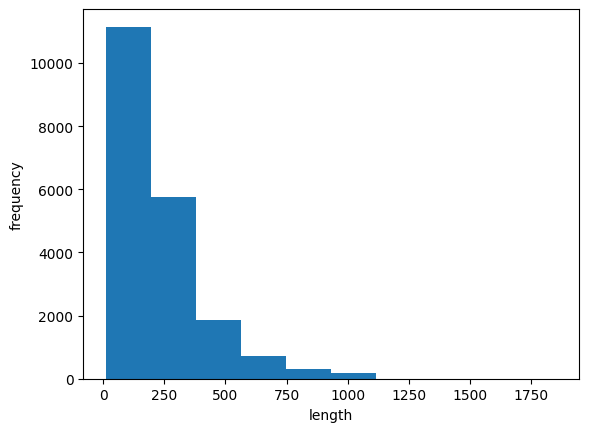

In [10]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

위 히스토그램을 보면 대부분 길이는 300 미만이다! 평균값이 중간값보다 높은 이유는 오른쪽 끝에 아주 큰 데이터가 있기 때문이다!  
고로 여기서는 대부분의 리뷰가 짧기에 중간값보다 훨씬 작은 100개의 단어만 사용한다. 하지만 100개보다 단어보다 작은 리뷰도 있는데  
이런 리뷰들은 길이를 100에 맞추기 위해 패딩이 필요하다! 보통 패딩을 나타내는 토큰으로는 0을 사용한다. 물론 수동으로 훈련 세트에  
20000개의 리뷰를 순회하면서 길이가 100이 되도록 잘라내거나 0으로 패딩할 수 있다. 하지만 자주 있는 번거로운 작업에는 항상 편리한  
도구가 준비되어 있음. keras는 sequence data의 길이를 맞추는 pad_sequence() 함수를 제공한다.

In [11]:
from keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100) # maxlen에 원하는 길이를 지정하면 이보다 긴 경우는 잘라내고 짧은 경우는 0으로 padding한다.

In [12]:
print(train_seq.shape)

(20000, 100)


In [13]:
print(train_seq[0])

[ 10   4  20   9   2   2   2   5  45   6   2   2  33   2   8   2 142   2
   5   2  17  73  17   2   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12   2  69   2 142  73   2   6
   2   7   2   2 188   2 103  14  31  10  10   2   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10   2 158]


In [14]:
print(train_input[0][-10:]) # 즉 맨 뒷부분은 남아있고 앞부분이 짤린다고 볼 수 있다!

[6, 2, 46, 7, 14, 20, 10, 10, 2, 158]


pad_sequences() 함수는 기본으로 maxlen보다 긴 sequence의 앞부분을 자른다. 이렇게 하는 이유는 일반적으로  
sequence의 뒷부분의 정보가 더 유용하리라 기대하기 때문이다! 영화 리뷰 데이터를 생각하면 리뷰 끝에 뭔가 결정적인  
소감을 말할 가능성이 높다고 보기 때문이다. 만약 sequence에서 뒷부분을 잘라내고 싶다면 pad_sequences()함수를 
truncating 매개변수의 값을 기본값 pre가 아닌 post로 바꾸면 된다!

In [15]:
print(train_seq[5]) # 앞에 0이 있는 것으로 보아 이 샘플의 길이는 100보다 작다는 것을 알 수 있다!

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2   2   2 183  10
  10  13  82  79   4   2  36  71   2   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14   2  56 129   2  10  10  21   2  94   2   2   2   2  11 190
  24   2   2   7  94   2   2  10  10  87   2  34  49   2   7   2   2   2
   2   2   2   2  46  48  64  18   4   2]


In [16]:
val_seq = pad_sequences(val_input, maxlen=100)

#### 순환 신경망 만들기  
keras는 여러 종류의 순환층 클래스를 제공한다. 그중에 가장 간단한 것은 SimpleRNN 클래스이다!  
이 클래스는 앞에서 본 신경망들과 거의 비슷한 기능을 수행한다. IMDB 리뷰 분류 문제는 이진분류이기에  
마지막 출력층은 1개의 뉴런을 가지고 시그모이드 활성화 함수를 사용해서 한다! 역시 Sequential class를  
이용해서 신경망 코드를 만들자! Sequential은 일반적인 인공 신경망 모두를 만들 수 있다!

In [17]:
import keras

model = keras.Sequential()
model.add(keras.layers.Input(shape=(100,200)))
model.add(keras.layers.SimpleRNN(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

위 코드는 앞서 본 신경망과 거의 비슷하지만 달라진 것은 SimpleRNN이 사용되었다는 것이다!  
Input함수의 입력은 (100,200)인데 1번째 차원이 100인 것은 샘플의 길이를 100으로 지정했기 때문이다!  
그럼 200은? 정수값에 있는 크기 속성을 없애고 각 정수를 고유하게 표현하기 위해 one-hot encoding을  
사용하는 것이다! 고로 앞에서 imdb.load_data() 함수에서 200개의 단어만 사용하도록 지정했기 때문에  
고유한 단어는 모두 200개이다! 그래서 이 범위를 one-hot encoding으로 나타내기 위해서는 200개의 배열이  
필요해서 배열의 길이가 200이어야 한다!

In [18]:
train_oh = keras.utils.to_categorical(train_seq)

In [19]:
print(train_oh.shape)

(20000, 100, 200)


In [20]:
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [21]:
print(np.sum(train_oh[0][0]))

1.0


In [22]:
val_oh = keras.utils.to_categorical(val_seq)

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 8)              │         1,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,681 (6.57 KB)

 Trainable params: 1,681 (6.57 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_oh, train_target, epochs=100, batch_size=64, validation_data=(val_oh, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5922 - loss: 0.6664 - val_accuracy: 0.6540 - val_loss: 0.6279
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6890 - loss: 0.5990 - val_accuracy: 0.6998 - val_loss: 0.5815
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7110 - loss: 0.5719 - val_accuracy: 0.7142 - val_loss: 0.5611
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7185 - loss: 0.5588 - val_accuracy: 0.7128 - val_loss: 0.5678
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7221 - loss: 0.5545 - val_accuracy: 0.7198 - val_loss: 0.5548
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7235 - loss: 0.5517 - val_accuracy: 0.7222 - val_loss: 0.5491
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7275 - loss: 0.5445 - val_accuracy: 0.7270 - val_loss: 0.5478
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7350 - loss: 0.5379 - 

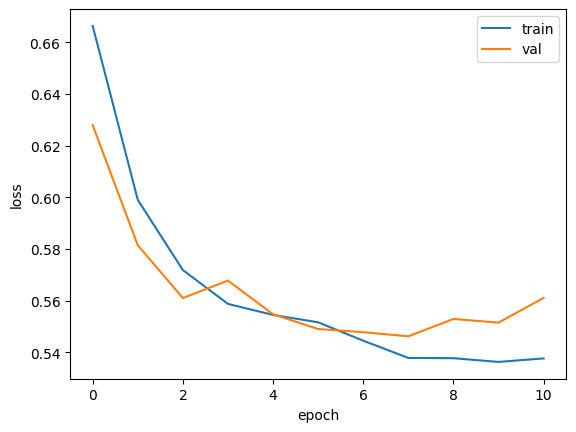

In [25]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [26]:
print(train_seq.nbytes, train_oh.nbytes) # train_seq 배열의 크기는 8MB 수준인데 3.2GB 수준이다!

8000000 3200000000


#### 단어 임베딩 사용하기  
순환신경망에서 텍스트를 처리할 때 즐겨 사용하는 방법은 단어 임베딩이다! 단어 임베딩은 각 단어를 고정된 크기의  
실수 벡터로 바꾸어 준다. 예를 들어, cat을 [0.2,0.1,1.3,...,0.1] 처럼 나타냄!  
이런 단어 임베딩은 one-hot encoding된 벡터보다 훨씬 의미 있는 값으로 채워져 있기에 자연어 처리에서 더 좋은 성능을  
낸다고 알려져 있다! 이런 단어 임베딩을 만드는 층은 이미 준비되어 있다! keras에서는 keras.layers 패키지 아래 Embedding 클래스로
임베딩 기능을 제공한다! 이 클래스를 모델에 추가하면 처음에는 다른 층처럼 모든 벡터가 랜덤하게 초기화되지만 훈련을 통해 데이터에서  
좋은 단어 임베딩을 학습한다! 단어 임베딩의 장점은 입력으로 정수 데이터를 받는다는 것이다. 즉, one-hot encoding으로 변경된 train_oh  
배열이 아니라 train_seq를 사용할 수 있다. 이 때문에 메모리를 훨씬 효율적으로 사용할 수 있다! 앞서 one-hot encoding은 샘플의 크기를  
200차원으로 늘렸는데, 이와 비슷하게 임베딩 층도 각각의 샘플을 고정된 크기의 벡터로 표현한다. 하지만 one-hot encoding과는 달리 훨씬  
작은 크기로도 단어를 잘 표현할 수 있다. 덕분에 메모리를 절약하고 더 많은 단어를 사용할 수 있다.

In [27]:
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [28]:
model_emb = keras.Sequential()
model_emb.add(keras.layers.Input(shape=(100,)))
model_emb.add(keras.layers.Embedding(500, 16))
model_emb.add(keras.layers.SimpleRNN(8))
model_emb.add(keras.layers.Dense(1, activation='sigmoid'))

In [29]:
model_emb.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,209 (32.07 KB)

 Trainable params: 8,209 (32.07 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_emb.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model_emb.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6041 - loss: 0.6530 - val_accuracy: 0.7250 - val_loss: 0.5643
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7249 - loss: 0.5565 - val_accuracy: 0.7018 - val_loss: 0.5843
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7509 - loss: 0.5270 - val_accuracy: 0.6136 - val_loss: 0.7274
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7571 - loss: 0.5168 - val_accuracy: 0.7544 - val_loss: 0.5215
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7886 - loss: 0.4684 - val_accuracy: 0.7726 - val_loss: 0.4905
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7965 - loss: 0.4530 - val_accuracy: 0.7634 - val_loss: 0.5118
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8092 - loss: 0.4310 - val_accuracy: 0.7776 - val_loss: 0.4886
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8163 - loss: 0.4198 -

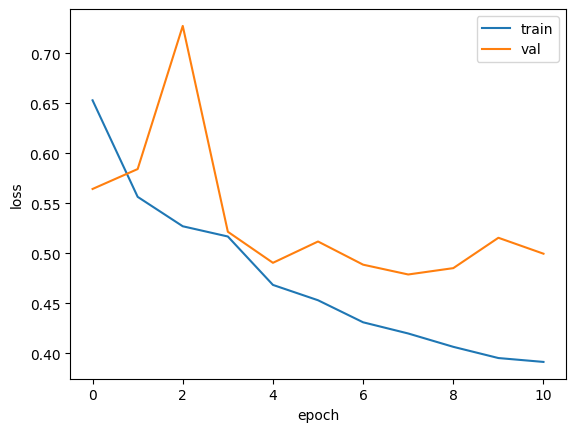

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [32]:
from keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_train, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

from keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [33]:
print(train_seq.shape, train_target.shape)

(20000, 100) (20000,)


In [34]:
import torch
train_seq = torch.tensor(train_seq)
val_seq = torch.tensor(val_seq)

In [35]:
print(train_target.dtype)

int64


In [36]:
train_target = torch.tensor(train_target, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)

In [37]:
print(train_target.dtype)

torch.float32


In [38]:
from torch.utils.data import TensorDataset, DataLoader 

train_dataset = TensorDataset(train_seq, train_target)
val_dataset = TensorDataset(val_seq, val_target)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [41]:
import torch.nn as nn

class IMDBRnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(500, 16)
        self.rnn = nn.RNN(16, 8, batch_first=True)
        self.dense = nn.Linear(8,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.rnn(x)
        outputs = self.dense(hidden[-1])
        return self.sigmoid(outputs)

In [42]:
model = IMDBRnn()

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

IMDBRnn(
  (embedding): Embedding(500, 16)
  (rnn): RNN(16, 8, batch_first=True)
  (dense): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [43]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [44]:
train_hist = []
val_hist = []
patience = 2
best_loss = -1
early_stopping_counter = 0

epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()
            
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    print(f"에포크: {epoch+1},",
          f"훈련 손실: {train_loss:.4f}, 검증 손실:{val_loss:.4f}")
    if best_loss == -1 or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_rnn_model.pt')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"{epoch+1}번째 에포크에서 조기 종료되었음")
            break

에포크: 1, 훈련 손실: 0.7037, 검증 손실:0.6934
에포크: 2, 훈련 손실: 0.6933, 검증 손실:0.6923
에포크: 3, 훈련 손실: 0.6912, 검증 손실:0.6909
에포크: 4, 훈련 손실: 0.6896, 검증 손실:0.6895
에포크: 5, 훈련 손실: 0.6878, 검증 손실:0.6876
에포크: 6, 훈련 손실: 0.6861, 검증 손실:0.6861
에포크: 7, 훈련 손실: 0.6841, 검증 손실:0.6841
에포크: 8, 훈련 손실: 0.6820, 검증 손실:0.6822
에포크: 9, 훈련 손실: 0.6798, 검증 손실:0.6800
에포크: 10, 훈련 손실: 0.6771, 검증 손실:0.6772
에포크: 11, 훈련 손실: 0.6740, 검증 손실:0.6743
에포크: 12, 훈련 손실: 0.6701, 검증 손실:0.6707
에포크: 13, 훈련 손실: 0.6645, 검증 손실:0.6648
에포크: 14, 훈련 손실: 0.6566, 검증 손실:0.6572
에포크: 15, 훈련 손실: 0.6455, 검증 손실:0.6486
에포크: 16, 훈련 손실: 0.6350, 검증 손실:0.6416
에포크: 17, 훈련 손실: 0.6267, 검증 손실:0.6307
에포크: 18, 훈련 손실: 0.6190, 검증 손실:0.6279
에포크: 19, 훈련 손실: 0.6136, 검증 손실:0.6239
에포크: 20, 훈련 손실: 0.6087, 검증 손실:0.6214
에포크: 21, 훈련 손실: 0.6064, 검증 손실:0.6172
에포크: 22, 훈련 손실: 0.5999, 검증 손실:0.6129
에포크: 23, 훈련 손실: 0.5987, 검증 손실:0.6108
에포크: 24, 훈련 손실: 0.5945, 검증 손실:0.6046
에포크: 25, 훈련 손실: 0.5896, 검증 손실:0.6040
에포크: 26, 훈련 손실: 0.5876, 검증 손실:0.6087
에포크: 27, 훈련 손실: 0.5864, 검증 손실:0.6032
에포크: 28, 훈

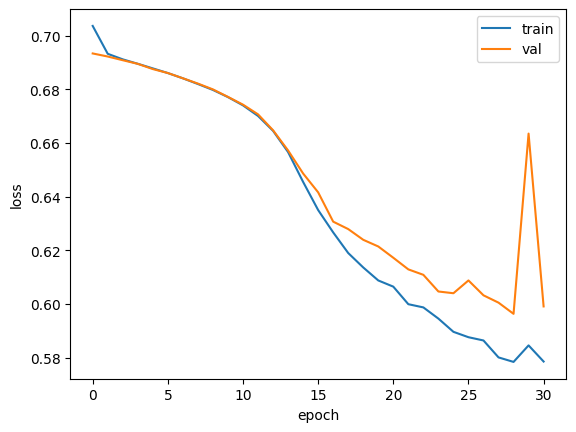

In [45]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [46]:
model.load_state_dict(torch.load('best_rnn_model.pt', weights_only=True))

model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predict = outputs > 0.5
        corrects += (predict.squeeze() == targets).sum().item()
        
accuracy = corrects / len(val_dataset)
print(f"검증 정확도: {accuracy:.4f}")

검증 정확도: 0.6862
